# Cellular Operator App Sentiment Analysis

### Airlangga Parikesit Wibowo

## Description

The project aims to analyze user reviews of mobile applications used for cellular operators, such as MyTelkomsel, MyXL, and similar apps, by scraping data from the Google Play Store. The focus is on performing sentiment analysis using natural language processing (NLP) techniques to understand user satisfaction and identify common issues.

User reviews were scraped from the review of MyTelkomsel, MyXL, MyIM3, and MYSF app in Google Play Store using Python libraries google-play-scraper.

## Goals

1. __Sentiment Classification__: To classify reviews about each providers app into categories such as positive or negative, giving a clear picture of customer satisfaction.

2. __Identify Key Issues__: To identify common complaints, praises, or suggestions shared by customers, helping each operator understand the issues that need immediate attention or improvement.

3. __Competitor Comparison__: To compare sentiment scores between the four providers, allowing for a better understanding of public perception and brand image relative to each other.

## Benefits

1. __Enhanced Customer Experience__: The analysis can help each operator understand how customers perceive their services and what improvements they desire. This can lead to targeted service improvements and enhanced customer satisfaction.

2. __Brand Reputation Management__: Understanding public sentiment enables the operators to manage their brand reputation effectively. They can address negative sentiment quickly and reinforce positive feedback through targeted communication or marketing.
   
3. __Market Position Insight__: By comparing sentiment data across competitors, operators can identify strengths and weaknesses relative to their competitors. This can inform strategies for market positioning and help differentiate their offerings.
   
4. __Product & Service Optimization__: Identifying common complaints (e.g., network issues, data speed problems, confusing UI) can guide operators to prioritize fixes or new features. This can directly impact user retention and reduce churn.

# Import Libraries

In [42]:
import os
from tqdm import tqdm
import unicodedata
from pathlib import Path
from collections import Counter

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
import spacy
# # Load the spaCy English model
# nlp = spacy.load('id_core_web_sm')

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk import ngrams
from nltk.corpus import stopwords
# from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
# from mpstemmer import MPStemmer

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Load Data

In [43]:
ROOT = Path("/kaggle/input/provider-review")
all_df = pd.read_csv(os.path.join(ROOT, "preprocessed_df_ft_1.csv"))

In [44]:
all_df[["clean_text", "sentiment"]].head()

,clean_text,sentiment
0,babi jaringan sudah jadi lambat lalet loading ...,negatif
1,tetap juara dan selalu menjadi produk telekomu...,positif
2,rusak aplikasinya keluar sendiri mulu login la...,negatif
3,mantap banyak bonusnya dan diskon khusus promo...,positif
4,jangan mahal mahal paket datanya,negatif


# Modelling

In [45]:
from sklearn.model_selection import KFold, train_test_split, cross_val_score, cross_val_predict
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import f1_score

In [46]:
# split data
X = all_df["clean_text"]
y = all_df["sentiment"]

def encode_label(label):
    if label == 'positif':
        return 1
    else:
        return 0

y = y.apply(lambda x: encode_label(x))

train_df, X_test, train_label, y_test = train_test_split(
    X, y, test_size=0.1, random_state=0
)
X_train, X_val, y_train, y_val = train_test_split(
    train_df, train_label, test_size=0.2, random_state=0
)

In [47]:
print(f"Train-val data size: {len(train_df)}")
print(f"Train data size: {len(X_train)}")
print(f"Validation data label: {len(X_val)}")
print(f"Test data size: {len(X_test)}")

Train-val data size: 1725
Train data size: 1380
Validation data label: 345
Test data size: 192


## SKlearn Machine Learning

In [48]:
def train_model(model, X_train, y_train, X_test, n_splits=5):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=0)

    # Create and train model
    trained_model = Pipeline([
        ('word_embedding', TfidfVectorizer()),
        ('classification_model', model)
    ])

    f1_score = cross_val_score(trained_model, X_train, y_train, cv=kfold, scoring='f1')
    precision_score = cross_val_score(trained_model, X_train, y_train, cv=kfold, scoring='precision')
    recall_score = cross_val_score(trained_model, X_train, y_train, cv=kfold, scoring='recall')
    
    scores = {
        "F1-score": f1_score,
        "Precision": precision_score,
        "Recall": recall_score
    }
    
    # Create a DataFrame for F1 scores of each fold
    f1_df = pd.DataFrame(scores, 
                         index=[f"fold_{fold+1}" for fold in range(n_splits)])
    
    avg_scores = {
        "F1-score":np.mean(f1_score),
        "Precision": np.mean(precision_score),
        "Recall": np.mean(recall_score)
    }
    # Calculate the average F1-score
    avg_score = pd.DataFrame([avg_scores], 
                             index=["avg_score"])
    
    # Concatenate the F1 scores and the average score
    f1_df = pd.concat([f1_df, avg_score])
    
    # fit the data and calculate score on test set
    trained_model.fit(X_train, y_train)
    y_pred = trained_model.predict(X_test)
    
    return f1_df, y_pred

In [49]:
svc = SVC()
trained_model_svc, y_pred = train_model(svc, train_df, train_label, X_test, n_splits=5)
trained_model_svc

,F1-score,Precision,Recall
fold_1,0.791209,0.900000,0.705882
fold_2,0.844720,0.957746,0.755556
fold_3,0.842767,0.957143,0.752809
fold_4,0.822857,0.960000,0.720000
fold_5,0.833333,0.945946,0.744681
avg_score,0.826977,0.944167,0.735786


In [50]:
svm_score = f1_score(y_test, y_pred)
print(f"Prediction score on test data: {svm_score*100:.2f} %")

Prediction score on test data: 82.35 %


### Hyperparameter Tuning

In [51]:
## hyperparameter tuning using GridSearch method with 5 kfold cross-validation
from sklearn.model_selection import GridSearchCV

kfold = KFold(n_splits=5, shuffle=True, random_state=0)
params = {
        'clf_model__C': [0.1, 1, 10, 100, 1000],  
        'clf_model__gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
        'clf_model__kernel': ['linear', 'rbf', 'poly', 'sigmoid']
    }
# Create and train model
trained_model = Pipeline([
    ('word_embedding', TfidfVectorizer()),
    ('clf_model', svc)
])

grid_search = GridSearchCV(estimator=trained_model,  
                           param_grid=params,
                           scoring='f1',
                           cv=kfold,
                           verbose=1) 

grid_search.fit(train_df, train_label)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('word_embedding', TfidfVectorizer()),
                                       ('clf_model', SVC())]),
             param_grid={'clf_model__C': [0.1, 1, 10, 100, 1000],
                         'clf_model__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'clf_model__kernel': ['linear', 'rbf', 'poly',
                                               'sigmoid']},
             scoring='f1', verbose=1)

In [52]:
# best score achieved during the GridSearchCV
print(f'GridSearch CV best score : {grid_search.best_score_*100:.2f} %\n')
# print parameters that give the best results
print(f'Parameters that give the best results :\n{grid_search.best_params_}\n')
# print estimator that was chosen by the GridSearch
print(f'\nEstimator that was chosen by the search :\n{grid_search.best_estimator_}\n')

GridSearch CV best score : 85.67 %

Parameters that give the best results :
{'clf_model__C': 1, 'clf_model__gamma': 1, 'clf_model__kernel': 'sigmoid'}


Estimator that was chosen by the search :
Pipeline(steps=[('word_embedding', TfidfVectorizer()),
                ('clf_model', SVC(C=1, gamma=1, kernel='sigmoid'))])



In [53]:
# score_gs = cross_val_score(grid_search, X_train, y_train, cv=kfold, scoring='f1')
# print(f"Cross-validation score:\n{score_gs}")

# print(f"Cross-validation score:\n{np.mean(score_gs)*100:.2f}")

In [54]:
# predict test set using gridsearch model
y_pred_gs = grid_search.best_estimator_.predict(X_test)

# show prediction score
svm_gs_score = f1_score(y_test, y_pred_gs)
print(f"Prediction score on test data: {svm_gs_score*100:.2f} %")

Prediction score on test data: 87.85 %


In [55]:
import joblib

joblib.dump(grid_search, 'svm_grid_search.pkl')

['svm_grid_search.pkl']

In [56]:
def mismatched_pred(df, gt_col, pred_col):
    """ Filters the DataFrame rows where the prediction does not match the true label.
    
    Args:
        df: pandas DataFrame containing the prediction and true label columns.
        gt_col: name of the column containing the true labels.
        pred_col: name of the column containing the predicted labels.
    
    Returns:
        DataFrame containing only the rows where prediction != true label.
    """
    # Filter rows where the true label is not equal to the prediction
    mismatches = df[df[gt_col] != df[pred_col]]
    
    return mismatches

test_df = pd.concat([X_test, y_test], axis=1).reset_index(drop=True)
test_df["prediction"] = y_pred
mismatched_pred(test_df, "sentiment", "prediction")

,clean_text,sentiment,prediction
2,sering dapat bonus,1,0
7,semoga makin terupdate dengan kemudahan2 yang ...,1,0
21,lebih banyak gratis vidio 30hari supaya lebih ...,1,0
23,hayang kuota gratis euy pelis dah bager mun te...,1,0
27,harga paket naik,1,0
31,sinyal jaringanya kuat kalo lagi didalam kota,1,0
35,banyak poin bisa dipakai,1,0
38,terus berkembang bosku dan jangan lupa membany...,1,0
41,tambah lagi bonus,1,0
44,perlu di tingkatkan lagi pengaplikasianya but ...,1,0


Text(0.5, 23.52222222222222, 'Prediction')

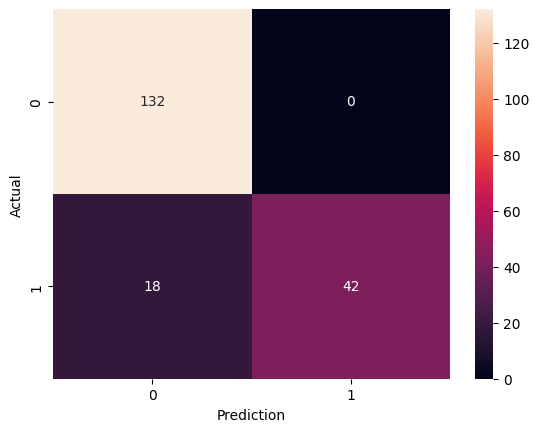

In [57]:
sns.heatmap(
    confusion_matrix(
        test_df['sentiment'], 
        test_df['prediction']
    ), 
    annot=True, 
    fmt='g'
)
plt.ylabel('Actual')
plt.xlabel('Prediction')

First test data evaluation before relabeling (test data 5%)

legend:
- checklist: will be relabeled
- 0: wrong detection
- x: no meaning
- <->: no idea
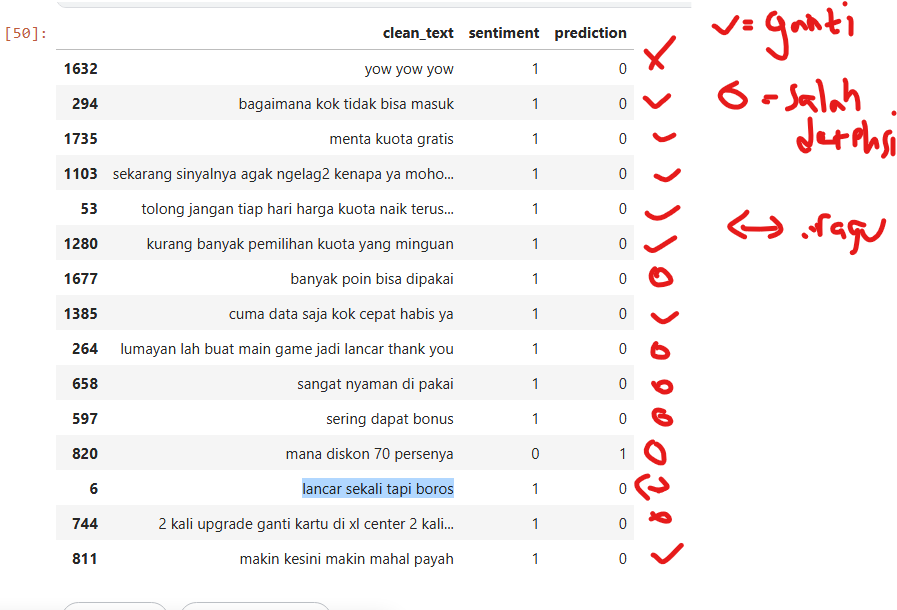

second test data (test data 10%, including previous test) (~75% F1-score)
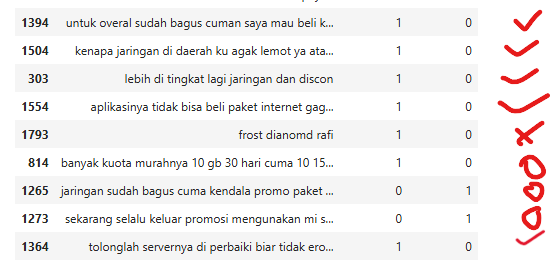

Third test:
- average training score: 0.817845
- GridSearch CV best score : 0.8485
- test data prediction score: 85.47 %

## LSTM

In [58]:
## importing modules
import random
import collections

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.callbacks import EarlyStopping
# from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional
# from tensorflow.keras.metrics import F1Score

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torchmetrics.classification import BinaryF1Score

# import torchtext
# from torchtext import data
# from torchtext.data.utils import get_tokenizer
# from torchtext import vocab

In [59]:
# all_df = pd.read_csv("/kaggle/working/preprocessed_df_ft.csv")

# split data
# X = all_df["clean_text"]
# y = all_df["sentiment"]

# def encode_label(label):
#     if label == 'positif':
#         return 1
#     else:
#         return 0

# y = y.apply(lambda x: encode_label(x))

# train_df, X_test, train_label, y_test = train_test_split(
#     X, y, test_size=0.1, random_state=0
# )
# X_train, X_val, y_train, y_val = train_test_split(
#     train_df, train_label, test_size=0.2, random_state=0
# )

In [60]:
## DEEP LEARNING PREPROCESSING
# Parameters for padding and OOV tokens
trunc_type='pre'
max_length = 200
padding_type='pre'
oov_tok = "<OOV>"

# Initialize the Tokenizer class
tokenizer = Tokenizer(oov_token=oov_tok)

# Generate the word index dictionary
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

# Generate and pad the training sequences
train_seq = tokenizer.texts_to_sequences(X_train)
train_pad = pad_sequences(train_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Generate and pad the validation sequences
val_seq = tokenizer.texts_to_sequences(X_val)
val_pad = pad_sequences(val_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Generate and pad the test sequences
test_seq = tokenizer.texts_to_sequences(X_test)
test_pad = pad_sequences(test_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Convert the labels lists into numpy arrays
train_labels = np.array(y_train)
val_labels = np.array(y_val)
test_labels = np.array(y_test)


# personal note: PyTorch accept padding and truncating 'pre', it cannot learn 'post' pad and trunc
# gained low metric score and don't update, unless there's special method to learn from 'post'

In [61]:
# building a vocab
vocabSize = len(tokenizer.index_word) + 1
print(f"Vocabulary size = {vocabSize}")

Vocabulary size = 2926


In [62]:
# create a review class to show len and item.
class ReviewDataset(Dataset):
    def __init__(self ,text, sentiment):
        self.text = text
        self.sentiment = sentiment
        
    def __len__(self):
        return len(self.text)

    def __getitem__(self,item):
        text = self.text[item]
        target = self.sentiment[item]
        return {
            "text": torch.tensor(text, dtype=torch.long),
            "label": torch.tensor(target, dtype=torch.long)
        }

In [63]:
# apply review class to data
train_data = ReviewDataset(text=train_pad, sentiment=train_labels)
val_data = ReviewDataset(text=val_pad, sentiment=val_labels)
test_data = ReviewDataset(text=test_pad, sentiment=test_labels)

# create dataloader
batch_size = 64

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

In [64]:
# obtain one batch of training data
one_batch = next(iter(train_loader))

print(f'Sample input size: {one_batch["text"].size()}')
print(f'Sample input: \n{one_batch["text"]}')
print(f'Sample input Label size: {one_batch["label"].size()}')
print(f'Sample input Label: \n{one_batch["label"]}')

Sample input size: torch.Size([64, 200])
Sample input: 
tensor([[   0,    0,    0,  ...,   43,  397,  246],
        [   0,    0,    0,  ...,   98,  643,  132],
        [   0,    0,    0,  ..., 1101,   15,  287],
        ...,
        [   0,    0,    0,  ...,  550,   25,  134],
        [   0,    0,    0,  ...,  358,    3,   64],
        [   0,    0,    0,  ...,   17,  436,  291]])
Sample input Label size: torch.Size([64])
Sample input Label: 
tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0,
        1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0])


In [65]:
class LSTMModel(nn.Module):
    def __init__(self, 
                 vocab_size: int, 
                 n_layers: int, 
                 hidden_dim: int, 
                 output_size: int, 
                 embedding_matrix=None,
                 embedding_dim=None,
                 use_pretrained: bool=True
                ):
        super(LSTMModel, self).__init__()
        
        self.vocab_size = vocab_size
        self.embedding_matrix = embedding_matrix
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.use_pretrained = use_pretrained
        
        # Define the embedding layer dimensions
        if use_pretrained:
            num_words = self.embedding_matrix.shape[0]
            embedd_dim = self.embedding_matrix.shape[1]
        else:
            # Define embedding dimensions if no pretrained weights are used
            num_words = vocab_size
            embedd_dim = embedding_dim
        
        self.embedding = nn.Embedding(num_embeddings=num_words, embedding_dim=embedd_dim)
        
        if use_pretrained:
            # initialize embedding layer's weights to pretrained embedding in embedding matrix
            self.embedding.weight = nn.Parameter(
                torch.tensor(embedding_matrix, dtype=torch.float32)
            )
            # Freeze embedding weights if using pretrained embeddings
            self.embedding.weight.requires_grad = False
        
        self.lstm = nn.LSTM(
            input_size=embedd_dim, hidden_size=self.hidden_dim, 
            bidirectional=True, num_layers=self.n_layers, 
            batch_first=True
        )
        
        self.dropout = nn.Dropout(0.5)
        
        self.fc = nn.Linear(in_features=hidden_dim*2, out_features=output_size)
        
    def forward(self, x):
        embedd = self.embedding(x)
        lstm_out, (hidden, _) = self.lstm(embedd)
#         print(f"{lstm_out.size()}")  torch.Size([128, 300, 128])
        out = self.dropout(lstm_out)
        out = out[:, -1]
#         print(f"{out.size()}") torch.Size([128, 128])
        out = self.fc(out)
#         print(f"{out.size()}") torch.Size([128, 1])
    
        return out

### Without pretrained Word Embedding

In [66]:
max_length = 200
batch_size = 64
hidden_dim = 64
output_size = 1
embedding_dim = 200
vocab_size = len(tokenizer.index_word) + 1
n_layers = 1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}\n")

model = LSTMModel(
    vocab_size=vocab_size, embedding_dim=embedding_dim, n_layers=n_layers, 
    hidden_dim=hidden_dim, output_size=output_size, use_pretrained=False
)
model = model.to(device)
print(model)

Device: cuda

LSTMModel(
  (embedding): Embedding(2926, 200)
  (lstm): LSTM(200, 64, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)


In [67]:
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        # applied xavier weigth initialization on linear layer 
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if "bias" in name:
                nn.init.zeros_(param)
            elif "weight" in name:
                # Orthogonal initialization helps maintain 
                # the norm of the gradient during backpropagation
                nn.init.orthogonal_(param)

model.apply(initialize_weights)

LSTMModel(
  (embedding): Embedding(2926, 200)
  (lstm): LSTM(200, 64, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [68]:
lr = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
criterion = nn.BCEWithLogitsLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

class EarlyStopper:
    # https://stackoverflow.com/questions/71998978/early-stopping-in-pytorch
    def __init__(self, patience=2, min_delta=0.01):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss - self.min_delta:
            self.min_validation_loss = validation_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [69]:
def train_step(dataloader: torch.utils.data.DataLoader, 
               model: torch.nn.Module, 
               criterion: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device = device):
    model.train()
    
    train_loss = []
    train_f1score = []
    metricf1 = BinaryF1Score().to(device)
    
    for i, data in enumerate(tqdm(dataloader, desc="Training...")):
        
        inputs = data['text'].to(device)
        labels = data['label'].to(device, dtype=torch.float) 
        
        # forward pass
        logits = model(inputs)
        
        # calculate loss and f1 score
        loss = criterion(logits.squeeze(), labels)
        probs = F.sigmoid(logits.squeeze())
        score = metricf1(probs, labels)
        
        # optimize zero grad
        optimizer.zero_grad()
        # backpropagation
        loss.backward()
        
        #`clip_grad_norm` helps prevent the exploding gradient problem in LSTMs
        nn.utils.clip_grad_norm_(model.parameters(), 5)
        
        # optimizer step (update weight/params)
        optimizer.step()
        
        train_loss.append(loss.item())
        train_f1score.append(score.cpu())
    
    return np.mean(train_loss), np.mean(train_f1score)

def validation_step(dataloader: torch.utils.data.DataLoader, 
                    model: torch.nn.Module, 
                    criterion: torch.nn.Module, 
                    device: torch.device = device):
    model.eval()
    
    val_loss = []
    val_f1score = []
    metricf1 = BinaryF1Score().to(device)
    
    with torch.inference_mode():
        for i, data in enumerate(tqdm(dataloader, desc="Validating...")):
            inputs = data['text'].to(device)
            labels = data['label'].to(device, dtype=torch.float) 
            
            logits = model(inputs)
            
            loss = criterion(logits.squeeze(), labels)
            probs = F.sigmoid(logits.squeeze())
            score = metricf1(probs, labels)
            
            val_loss.append(loss.item())
            val_f1score.append(score.cpu())
    
    return np.mean(val_loss), np.mean(val_f1score)

In [70]:
def training(train_dataloader: torch.utils.data.DataLoader,
             val_dataloader: torch.utils.data.DataLoader,
             model: torch.nn.Module,
             optimizer: torch.optim.Optimizer, 
             criterion: torch.nn.Module,
             epochs: int = 10,
             patience: int = 1):
    
    metrics = collections.defaultdict(list)
    best_val_loss = float("inf")
    
#     early_stopper = EarlyStopper(patience=patience, min_delta=0.1)
    
    for epoch in range(epochs):
        train_loss, train_f1score = train_step(
            train_dataloader, model, criterion, optimizer, device
        )
        val_loss, val_f1score = validation_step(
            val_dataloader, model, criterion, device
        )

        metrics['train_loss'].append(train_loss)
        metrics['train_f1score'].append(train_f1score)
        metrics['val_loss'].append(val_loss)
        metrics['val_f1score'].append(val_f1score)
        
        scheduler.step(val_loss)
        
#         if early_stopper.early_stop(val_loss):  
#             print(f"## Initiate early stopping at epoch {epoch}")
#             break
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "lstm_model.pt")
            
        print(f"Epoch: {epoch}")
        print(f"train_loss: {train_loss:.3f} - train_f1-score: {train_f1score:.3f}"
              f"  -  "
              f"val_loss: {val_loss:.3f} - val_f1-score: {val_f1score:.3f}")
        
    return metrics

In [71]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_no_pretrain = training(
    model=model,
    train_dataloader=train_loader,
    val_dataloader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    epochs=40,
    patience=2
)

Validating...: 100%|██████████| 6/6 [00:00<00:00, 252.29it/s]


Epoch: 0
train_loss: 0.688 - train_f1-score: 0.394  -  val_loss: 0.672 - val_f1-score: 0.386


Validating...: 100%|██████████| 6/6 [00:00<00:00, 259.15it/s]


Epoch: 1
train_loss: 0.654 - train_f1-score: 0.450  -  val_loss: 0.653 - val_f1-score: 0.450


Validating...: 100%|██████████| 6/6 [00:00<00:00, 285.26it/s]


Epoch: 2
train_loss: 0.633 - train_f1-score: 0.473  -  val_loss: 0.635 - val_f1-score: 0.475


Validating...: 100%|██████████| 6/6 [00:00<00:00, 325.86it/s]


Epoch: 3
train_loss: 0.609 - train_f1-score: 0.511  -  val_loss: 0.619 - val_f1-score: 0.484


Validating...: 100%|██████████| 6/6 [00:00<00:00, 320.87it/s]


Epoch: 4
train_loss: 0.593 - train_f1-score: 0.538  -  val_loss: 0.602 - val_f1-score: 0.499


Validating...: 100%|██████████| 6/6 [00:00<00:00, 325.08it/s]


Epoch: 5
train_loss: 0.575 - train_f1-score: 0.529  -  val_loss: 0.584 - val_f1-score: 0.529


Validating...: 100%|██████████| 6/6 [00:00<00:00, 268.62it/s]


Epoch: 6
train_loss: 0.549 - train_f1-score: 0.596  -  val_loss: 0.566 - val_f1-score: 0.586


Validating...: 100%|██████████| 6/6 [00:00<00:00, 321.81it/s]


Epoch: 7
train_loss: 0.529 - train_f1-score: 0.592  -  val_loss: 0.548 - val_f1-score: 0.631


Validating...: 100%|██████████| 6/6 [00:00<00:00, 321.37it/s]


Epoch: 8
train_loss: 0.510 - train_f1-score: 0.648  -  val_loss: 0.529 - val_f1-score: 0.655


Validating...: 100%|██████████| 6/6 [00:00<00:00, 326.09it/s]


Epoch: 9
train_loss: 0.475 - train_f1-score: 0.686  -  val_loss: 0.508 - val_f1-score: 0.663


Validating...: 100%|██████████| 6/6 [00:00<00:00, 321.43it/s]


Epoch: 10
train_loss: 0.454 - train_f1-score: 0.703  -  val_loss: 0.487 - val_f1-score: 0.647


Validating...: 100%|██████████| 6/6 [00:00<00:00, 327.08it/s]


Epoch: 11
train_loss: 0.426 - train_f1-score: 0.709  -  val_loss: 0.466 - val_f1-score: 0.636


Validating...: 100%|██████████| 6/6 [00:00<00:00, 311.15it/s]


Epoch: 12
train_loss: 0.402 - train_f1-score: 0.719  -  val_loss: 0.444 - val_f1-score: 0.646


Validating...: 100%|██████████| 6/6 [00:00<00:00, 316.13it/s]


Epoch: 13
train_loss: 0.374 - train_f1-score: 0.723  -  val_loss: 0.422 - val_f1-score: 0.657


Validating...: 100%|██████████| 6/6 [00:00<00:00, 313.20it/s]


Epoch: 14
train_loss: 0.340 - train_f1-score: 0.750  -  val_loss: 0.402 - val_f1-score: 0.687


Validating...: 100%|██████████| 6/6 [00:00<00:00, 313.19it/s]


Epoch: 15
train_loss: 0.317 - train_f1-score: 0.753  -  val_loss: 0.387 - val_f1-score: 0.704


Validating...: 100%|██████████| 6/6 [00:00<00:00, 251.99it/s]


Epoch: 16
train_loss: 0.302 - train_f1-score: 0.769  -  val_loss: 0.375 - val_f1-score: 0.716


Validating...: 100%|██████████| 6/6 [00:00<00:00, 247.71it/s]


Epoch: 17
train_loss: 0.282 - train_f1-score: 0.784  -  val_loss: 0.366 - val_f1-score: 0.723


Validating...: 100%|██████████| 6/6 [00:00<00:00, 322.78it/s]


Epoch: 18
train_loss: 0.268 - train_f1-score: 0.806  -  val_loss: 0.356 - val_f1-score: 0.734


Validating...: 100%|██████████| 6/6 [00:00<00:00, 275.41it/s]


Epoch: 19
train_loss: 0.257 - train_f1-score: 0.814  -  val_loss: 0.347 - val_f1-score: 0.767


Validating...: 100%|██████████| 6/6 [00:00<00:00, 284.66it/s]


Epoch: 20
train_loss: 0.244 - train_f1-score: 0.831  -  val_loss: 0.337 - val_f1-score: 0.765


Validating...: 100%|██████████| 6/6 [00:00<00:00, 273.18it/s]


Epoch: 21
train_loss: 0.230 - train_f1-score: 0.836  -  val_loss: 0.330 - val_f1-score: 0.777


Validating...: 100%|██████████| 6/6 [00:00<00:00, 234.70it/s]


Epoch: 22
train_loss: 0.223 - train_f1-score: 0.836  -  val_loss: 0.322 - val_f1-score: 0.782


Validating...: 100%|██████████| 6/6 [00:00<00:00, 311.65it/s]


Epoch: 23
train_loss: 0.213 - train_f1-score: 0.859  -  val_loss: 0.317 - val_f1-score: 0.784


Validating...: 100%|██████████| 6/6 [00:00<00:00, 303.82it/s]


Epoch: 24
train_loss: 0.201 - train_f1-score: 0.882  -  val_loss: 0.310 - val_f1-score: 0.788


Validating...: 100%|██████████| 6/6 [00:00<00:00, 280.19it/s]


Epoch: 25
train_loss: 0.189 - train_f1-score: 0.881  -  val_loss: 0.313 - val_f1-score: 0.792


Validating...: 100%|██████████| 6/6 [00:00<00:00, 266.87it/s]


Epoch: 26
train_loss: 0.173 - train_f1-score: 0.892  -  val_loss: 0.301 - val_f1-score: 0.803


Validating...: 100%|██████████| 6/6 [00:00<00:00, 297.69it/s]


Epoch: 27
train_loss: 0.170 - train_f1-score: 0.899  -  val_loss: 0.296 - val_f1-score: 0.808


Validating...: 100%|██████████| 6/6 [00:00<00:00, 275.01it/s]


Epoch: 28
train_loss: 0.164 - train_f1-score: 0.915  -  val_loss: 0.293 - val_f1-score: 0.811


Validating...: 100%|██████████| 6/6 [00:00<00:00, 259.70it/s]


Epoch: 29
train_loss: 0.155 - train_f1-score: 0.907  -  val_loss: 0.292 - val_f1-score: 0.817


Validating...: 100%|██████████| 6/6 [00:00<00:00, 300.92it/s]


Epoch: 30
train_loss: 0.146 - train_f1-score: 0.926  -  val_loss: 0.288 - val_f1-score: 0.822


Validating...: 100%|██████████| 6/6 [00:00<00:00, 307.17it/s]


Epoch: 31
train_loss: 0.140 - train_f1-score: 0.923  -  val_loss: 0.288 - val_f1-score: 0.813


Validating...: 100%|██████████| 6/6 [00:00<00:00, 315.69it/s]


Epoch: 32
train_loss: 0.132 - train_f1-score: 0.924  -  val_loss: 0.290 - val_f1-score: 0.815


Validating...: 100%|██████████| 6/6 [00:00<00:00, 279.45it/s]


Epoch: 33
train_loss: 0.128 - train_f1-score: 0.932  -  val_loss: 0.284 - val_f1-score: 0.831


Validating...: 100%|██████████| 6/6 [00:00<00:00, 286.77it/s]


Epoch: 34
train_loss: 0.118 - train_f1-score: 0.939  -  val_loss: 0.283 - val_f1-score: 0.831


Validating...: 100%|██████████| 6/6 [00:00<00:00, 267.45it/s]


Epoch: 35
train_loss: 0.115 - train_f1-score: 0.942  -  val_loss: 0.296 - val_f1-score: 0.828


Validating...: 100%|██████████| 6/6 [00:00<00:00, 327.65it/s]


Epoch: 36
train_loss: 0.111 - train_f1-score: 0.942  -  val_loss: 0.282 - val_f1-score: 0.825


Validating...: 100%|██████████| 6/6 [00:00<00:00, 290.17it/s]


Epoch: 37
train_loss: 0.103 - train_f1-score: 0.951  -  val_loss: 0.286 - val_f1-score: 0.821


Validating...: 100%|██████████| 6/6 [00:00<00:00, 259.55it/s]


Epoch: 38
train_loss: 0.095 - train_f1-score: 0.957  -  val_loss: 0.285 - val_f1-score: 0.833


Validating...: 100%|██████████| 6/6 [00:00<00:00, 280.81it/s]


Epoch: 39
train_loss: 0.092 - train_f1-score: 0.960  -  val_loss: 0.285 - val_f1-score: 0.838


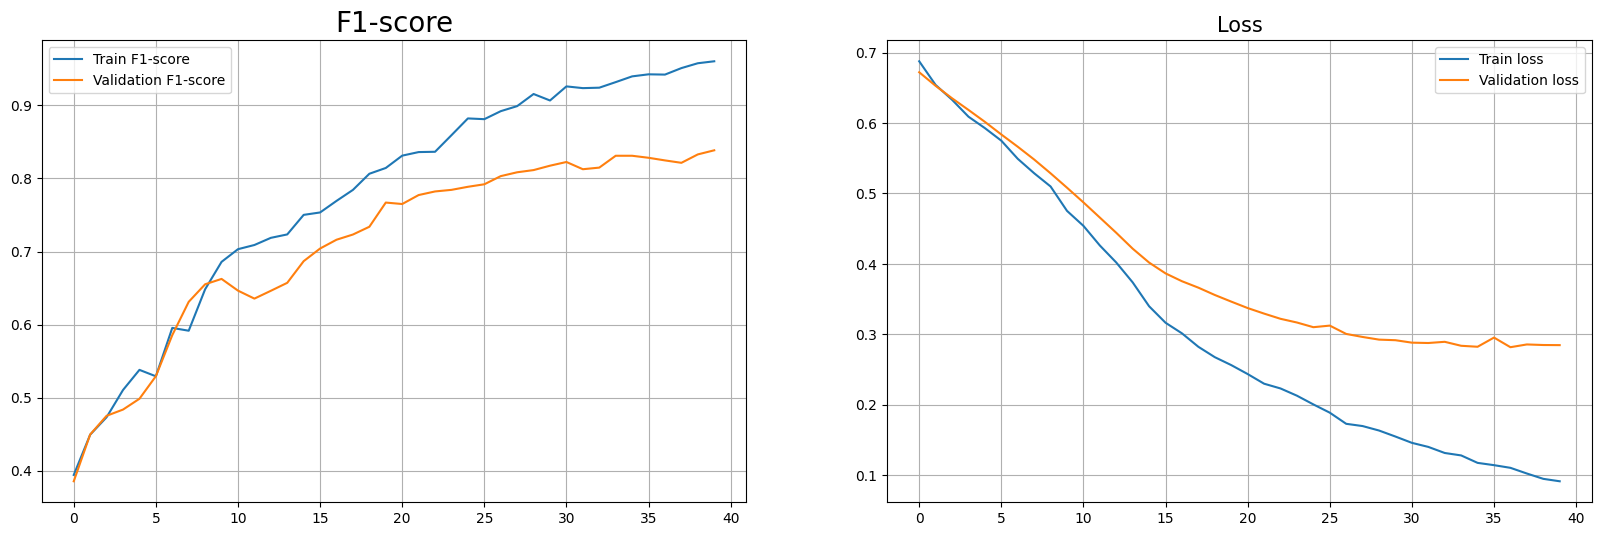

In [72]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(model_no_pretrain['train_f1score'], label='Train F1-score')
plt.plot(model_no_pretrain['val_f1score'], label='Validation F1-score')
plt.title("F1-score", fontsize=20)
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(model_no_pretrain['train_loss'], label='Train loss')
plt.plot(model_no_pretrain['val_loss'], label='Validation loss')
plt.title("Loss", fontsize=15)
plt.legend()
plt.grid()

plt.show()

In [73]:
test_loss, test_f1score = validation_step(
            test_loader, model, criterion, device
        )

print(f"Prediction score on test data: {test_f1score*100:.3f} %")

Validating...: 100%|██████████| 3/3 [00:00<00:00, 195.05it/s]

Prediction score on test data: 82.393 %


In [74]:
def generate_prediciton(dataloader: torch.utils.data.DataLoader, 
                        model: torch.nn.Module, 
                        criterion: torch.nn.Module, 
                        device: torch.device = device):
    model.eval()
    all_preds = []
    
    with torch.inference_mode():
        for i, data in enumerate(tqdm(dataloader, desc="Generate Prediction...")):
            inputs = data['text'].to(device)
            labels = data['label'].to(device, dtype=torch.float)
            
            logits = model(inputs)

            # Ensure logits and labels have matching shape
            logits = logits.view(-1)  # Ensure logits shape is [batch_size] or [batch_size, 1]
            labels = labels.view(-1)  # Ensure labels shape is [batch_size]
            
            loss = criterion(logits, labels)
            probs = F.sigmoid(logits)
            
            # convert probabilities to binary predictions (0 or 1)
            preds = (probs >= 0.5).int()
            
            all_preds.extend(preds.cpu().numpy())
    
    return all_preds

In [75]:
y_pred_lstm = generate_prediciton(test_loader, model, criterion, device)

test_df_lstm = pd.concat([X_test, y_test], axis=1).reset_index(drop=True)
test_df_lstm["prediction"] = y_pred_lstm
mismatched_pred(test_df_lstm, "sentiment", "prediction")

Generate Prediction...: 100%|██████████| 3/3 [00:00<00:00, 317.41it/s]


,clean_text,sentiment,prediction
2,sering dapat bonus,1,0
7,semoga makin terupdate dengan kemudahan2 yang ...,1,0
21,lebih banyak gratis vidio 30hari supaya lebih ...,1,0
31,sinyal jaringanya kuat kalo lagi didalam kota,1,0
35,banyak poin bisa dipakai,1,0
42,terima kasih kasih untuk telcomsel memberi pro...,1,0
44,perlu di tingkatkan lagi pengaplikasianya but ...,1,0
53,untung masih 30ribu coba kalo top up jutan ter...,0,1
72,kalo lagi huja sinyal kurang bagus,0,1
73,lancar sekali tapi boros,0,1


Text(0.5, 23.52222222222222, 'Prediction')

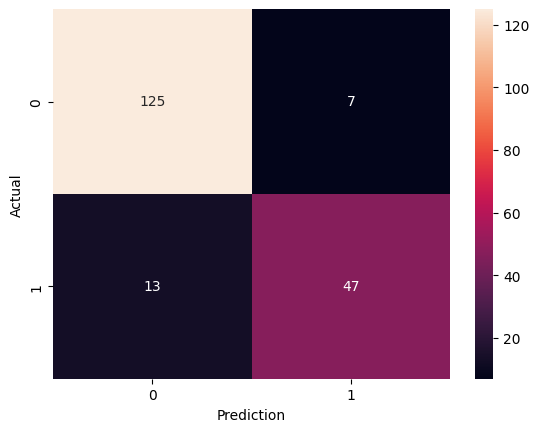

In [76]:
sns.heatmap(
    confusion_matrix(
        test_df_lstm['sentiment'], 
        test_df_lstm['prediction']
    ), 
    annot=True, 
    fmt='g'
)
plt.ylabel('Actual')
plt.xlabel('Prediction')

## Gemini LLM

In [77]:
!pip install -q -U google-generativeai

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [78]:
import pathlib
import textwrap

import google.generativeai as genai

from IPython.display import display
from IPython.display import Markdown

In [79]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
GOOGLE_API_KEY = user_secrets.get_secret("GOOGLE_API_KEY")

genai.configure(api_key=GOOGLE_API_KEY)

In [80]:
for m in genai.list_models():
  if 'generateContent' in m.supported_generation_methods:
    print(m.name)

models/gemini-1.0-pro-latest
models/gemini-1.0-pro
models/gemini-pro
models/gemini-1.0-pro-001
models/gemini-1.0-pro-vision-latest
models/gemini-pro-vision
models/gemini-1.5-pro-latest
models/gemini-1.5-pro-001
models/gemini-1.5-pro-002
models/gemini-1.5-pro
models/gemini-1.5-pro-exp-0801
models/gemini-1.5-pro-exp-0827
models/gemini-1.5-flash-latest
models/gemini-1.5-flash-001
models/gemini-1.5-flash-001-tuning
models/gemini-1.5-flash
models/gemini-1.5-flash-exp-0827
models/gemini-1.5-flash-002
models/gemini-1.5-flash-8b
models/gemini-1.5-flash-8b-001
models/gemini-1.5-flash-8b-latest
models/gemini-1.5-flash-8b-exp-0827
models/gemini-1.5-flash-8b-exp-0924
models/learnlm-1.5-pro-experimental
models/gemini-exp-1114
models/gemini-exp-1121


In [87]:
llm_model = genai.GenerativeModel("gemini-1.5-flash")

In [88]:
test_df_llm = pd.concat([X_test, y_test], axis=1).reset_index(drop=True)

# test_df_llm_sample = test_df_llm.sample(20)
test_df_llm["prediction"] = ""

batches = []
batch_size = 12

for i, batch in enumerate(range(0, len(test_df_llm), batch_size)):
    batches.append(test_df_llm[batch:batch+batch_size])
    print(f"batch {i} has {len(test_df_llm[batch:batch+batch_size])} records")

batch 0 has 12 records
batch 1 has 12 records
batch 2 has 12 records
batch 3 has 12 records
batch 4 has 12 records
batch 5 has 12 records
batch 6 has 12 records
batch 7 has 12 records
batch 8 has 12 records
batch 9 has 12 records
batch 10 has 12 records
batch 11 has 12 records
batch 12 has 12 records
batch 13 has 12 records
batch 14 has 12 records
batch 15 has 12 records


In [89]:
def gemini_batching_api(batch, curr_batch, total_batch):
    """
    steps:
    1. convert dataframe to json 
    2. prepare gemini prompt
    3. calling gemini api
    """
    print(f"processing batch#: {curr_batch+1} of {total_batch}")

    test_df_json = batch[["clean_text","prediction"]].to_json(orient='records')

    prompt = f"""
    Your are an expert linguist in Indonesian language (both formal and informal/slang) who is good at classifying customer review sentiments in Indonesian language into positive or negative labels.
    You are here to help me classify customer reviews into: positive(label=1) and negative(label=0).
    Customer reviews are provided between three backticks.
    In your output, only return the json code back as output, which is provided between three backticks.
    Your task is to update predicted labels under 'predicted' in the json code.
    Don't make any changes to json code format, please.
    
    ```
    {test_df_json}
    ```
    """
    response = llm_model.generate_content(prompt)
    json_dt = response.text.strip("`")
    json_dt = json_dt.strip().split('\n', 1)[1].rsplit('\n', 1)[0]
    json_dt = json.loads(json_dt)
    
    time.sleep(10)

    return json_dt

In [110]:
import json
import time

batch_count = len(batches)
responses = []
for i in range(len(batches)):
    responses.extend(gemini_batching_api(batches[i],i,batch_count))

processing batch#: 1 of 16
processing batch#: 2 of 16
processing batch#: 3 of 16
processing batch#: 4 of 16
processing batch#: 5 of 16
processing batch#: 6 of 16
processing batch#: 7 of 16
processing batch#: 8 of 16
processing batch#: 9 of 16
processing batch#: 10 of 16
processing batch#: 11 of 16
processing batch#: 12 of 16
processing batch#: 13 of 16
processing batch#: 14 of 16
processing batch#: 15 of 16
processing batch#: 16 of 16


In [113]:
sample_df = pd.DataFrame(responses)

test_df_llm["prediction"] = sample_df["prediction"].astype("int").values
test_df_llm

,clean_text,sentiment,prediction
0,wau adminya mau bantu walau agak telat terima ...,1,1
1,nice saya suka,1,1
2,sering dapat bonus,1,1
3,kenapa sih jaringanya jelek kali sekarang masa...,0,0
4,jaringan sekarang makin buruk,0,0
...,...,...,...
187,m3 memang jos,1,1
188,aplikasi yang sangat membantu,1,1
189,kenapa pulsa selalu tersedot padahal sudah men...,0,0
190,bagus buat main games,1,1


In [115]:
# show prediction score
llm_score = f1_score(test_df_llm["sentiment"], test_df_llm["prediction"])
print(f"Prediction score on test data: {llm_score*100:.2f} %")

Prediction score on test data: 93.91 %


Text(0.5, 23.52222222222222, 'Prediction')

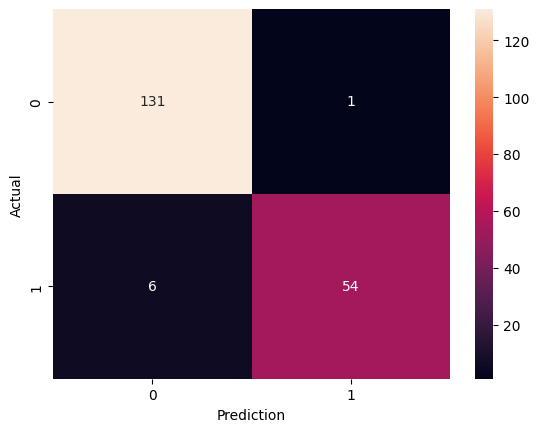

In [116]:
sns.heatmap(
    confusion_matrix(
        test_df_llm['sentiment'], 
        test_df_llm['prediction']
    ), 
    annot=True, 
    fmt='g'
)
plt.ylabel('Actual')
plt.xlabel('Prediction')

In [117]:
mismatched_pred(test_df_llm, "sentiment", "prediction")

,clean_text,sentiment,prediction
23,hayang kuota gratis euy pelis dah bager mun te...,1,0
27,harga paket naik,1,0
44,perlu di tingkatkan lagi pengaplikasianya but ...,1,0
59,kalo bisa lebih banyak bonus kuota dan lebih d...,1,0
66,saya orangnya simple kalau harga kuota masih m...,0,1
93,maf sedikit saran untuk jaringan di wilayah la...,1,0
153,frost dianomd rafi,1,0


# Evaluation

In [118]:
all_score_dict = {
    "SVM": f"{svm_score*100:.3f}",
    "SVM_GridSearch": f"{svm_gs_score*100:.3f}",
    "LSTM": f"{test_f1score*100:.3f}",
    "Gemini_LLM": f"{llm_score*100:.3f}" 
}
all_score_df = pd.DataFrame(all_score_dict, index=["Test Score (%)"]).T
all_score_df

,Test Score (%)
SVM,82.353
SVM_GridSearch,87.850
LSTM,82.393
Gemini_LLM,93.913
